In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import pandas as pd
import re
import requests
import time
from datetime import datetime
from datetime import timezone
import csv
import mwparserfromhell
import sys
import tqdm

In [7]:
df = pd.read_csv('../../datas/final/large_db_preprocess.csv')
articles = sorted(df['article'].unique().tolist())

In [8]:
# articles look clean and ready to be used
articles

['2004 Ukrainian presidential election',
 '2014 Russian annexation of Crimea',
 '2014 pro-Russian unrest in Ukraine',
 '2022 Russian invasion of Ukraine',
 'Abortion in Ukraine',
 'Administrative divisions of Ukraine',
 'Alexander II of Russia',
 'Armed Forces of Ukraine',
 'Bessarabia',
 'Buddhism in Ukraine',
 'Bukovina',
 'COVID-19 pandemic in Ukraine',
 'Catherine the Great',
 'Censuses in Ukraine',
 'Christianity in Russia',
 'Christmas in Ukraine',
 'Communist Party of the Soviet Union',
 'Crimea',
 'Crimean Tatars',
 'Culture of Ukraine',
 'Demographics of Ukraine',
 'Dissolution of the Soviet Union',
 'Eastern Front (World War I)',
 'Eastern Front (World War II)',
 'Economy of Ukraine',
 'Education in Ukraine',
 'Epiphanius I of Ukraine',
 'Euromaidan',
 'Flag of Ukraine',
 'Football in Ukraine',
 'Foreign relations of Ukraine',
 'Galicia (Eastern Europe)',
 'Geography of Ukraine',
 'Government of Ukraine',
 "Government of the Ukrainian People's Republic in exile",
 'History of

## Protection Status

We are first looking into the protection status feature as it is the easiest to retrieve. Indeed, the Wikimedia Action API does have a special parameter ```prop = info```, ```infoprop = protection``` that allows us to gather this information.

In [61]:
URL = "https://en.wikipedia.org/w/api.php"
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

# allow us to know when to start our timeline to display the protection status evolution for each article 

def get_article_creation_date(title):
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": title,
        "rvlimit": 1,
        "rvprop": "timestamp|user|comment",
        "rvdir": "newer"  
    }

    r = requests.get(URL, params=params, headers=HEADERS)
    data = r.json()

    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return None

    rev = page["revisions"][0]
    return {
        "timestamp": rev["timestamp"],
        "user": rev.get("user"),
        "comment": rev.get("comment")
    }


def get_article_protection_status(article_title):
    """
    Get the protection status of an article
    The status can be :
    - fully protected 
    - semi-protected
    - template protected
    - ...
    """
    
    session = requests.Session()
    session.headers.update(HEADERS)

    params = {
        "action": "query",
        "titles": article_title,
        "prop": "info",
        "inprop": "protection",
        "format": "json"
    }

    response = requests.get(url=URL, params=params, headers=HEADERS)
    data = response.json()

    # Extract page object (the pageid is unknown => key is not fixed)
    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return {"status": "missing", "protections": []}

    protections = page.get("protection", [])

    # If no protection entries → page is fully open
    if not protections:
        return {"status": "unprotected", "protections": []} 

    # Convert the protection status to understand better
    status = "custom protection"
    for prot in protections:
        action = prot.get("type")
        level = prot.get("level")

        if action == "edit":
            if level == "autoconfirmed":
                status = "semi-protected"
            elif level == "extendedconfirmed":
                status = "extended-protected"
            elif level == "sysop":
                status = "fully protected"
        elif action == "move" and level == "sysop":
            status = "move-protected"

    return {
        "status": status,
        "protections": protections  # raw list for further analysis
    }

def get_article_protection_history(article_title):
    """
    Retrieve the full protection history of an article using MediaWiki logevents.
    Returns a sorted list of protection events including timestamp, action,
    protection levels, expiry, and comments.
    """

    session = requests.Session()
    session.headers.update(HEADERS)

    events = []
    cont = {}

    while True:
        params = {
            "action": "query",
            "list": "logevents",
            "letype": "protect",
            "letitle": article_title,
            "lelimit": "max",
            "format": "json",
            **cont
        }

        response = session.get(URL, params=params)
        data = response.json()

        for ev in data["query"]["logevents"]:
            event = {
                "timestamp": ev.get("timestamp"),
                "user": ev.get("user"),
                "action": ev.get("action"),        # protect / modify / unprotect / move_prot
                "comment": ev.get("comment"),

                # details with levels and expiry (may be missing)
                "protection": ev.get("params", {}).get("details", []),
            }
            events.append(event)

        # Continue if there's more data
        if "continue" in data:
            cont = data["continue"]
        else:
            break

    # Sort chronologically
    events.sort(key=lambda x: x["timestamp"])

    return events

# -
# Those methods will help us cleaning our API JSON output because the format may not be the same through the evolution
# of wikipedia
# -

def parse_old_protection(comment):
    """
    Extracts old-style MediaWiki protection settings from a log comment.
    Example: "edit war [edit=sysop:move=sysop]"
    Returns dict: {"edit": "sysop", "move": "sysop"}
    """
    match = re.search(r"\[(.*?)\]", comment)
    if not match:
        return {}

    content = match.group(1)
    rules = content.split(":")

    prot = {}
    for rule in rules:
        if "=" in rule:
            key, value = rule.split("=", 1)
            prot[key.strip()] = value.strip()

    return prot


def resolve_status(prot_dict):
    """
    Convert a dict of edit/move protection settings to a unified status string.
    Used for new-style AND old-style protections.
    """
    edit = prot_dict.get("edit")
    move = prot_dict.get("move")

    if edit == "sysop":
        return "fully protected"
    if edit == "extendedconfirmed":
        return "extended-protected"
    if edit == "autoconfirmed":
        return "semi-protected"
    if move == "sysop":
        return "move-protected"

    return "unprotected"

# -
# This function allow us to build our timeline by knowing when the protection status changed for a specific article
# This function was almost fully generated with an LLM.
# -

def build_protection_timeline(article_title):
    """
    Build chronological protection timeline with:
      - new-style MW protection data (post-2010)
      - old-style comment-embedded protection info (pre-2010)

    Output:
        [
          {"start": datetime, "end": datetime, "status": "unprotected"},
          {"start": datetime, "end": datetime, "status": "semi-protected"},
          ...
        ]
    """

    events = get_article_protection_history(article_title)

    # If no protection events at all, we add always unprotected
    if not events:
        # Try to use creation date if available; otherwise return None/None
        creation_info = get_article_creation_date(article_title)
        if creation_info and "timestamp" in creation_info:
            creation_dt = datetime.fromisoformat(
                creation_info["timestamp"].replace("Z", "+00:00")
            )
            return [{
                "start": creation_dt,
                "end": datetime.utcnow(),
                "status": "unprotected"
            }]
        else:
            return [{
                "start": None,
                "end": None,
                "status": "unprotected"
            }]

    # Initial state: article just born, unprotected 
    creation_info = get_article_creation_date(article_title)
    creation_dt = datetime.fromisoformat(
        creation_info["timestamp"].replace("Z", "+00:00")
    )

    timeline = []
    current_status = "unprotected"
    current_start = creation_dt

    # events should already be chronological, but just to be safe
    events = sorted(events, key=lambda e: e["timestamp"])

    for ev in events:
        timestamp = datetime.fromisoformat(ev["timestamp"].replace("Z", "+00:00"))
        action = ev.get("action")
        protections = ev.get("protection", [])
        comment = ev.get("comment", "")
        
        
        expiry_dates = []
        for p in protections:
            expiry = p.get('expiry')
            if expiry and expiry != 'infinite':
                expiry_dates.append(datetime.fromisoformat(expiry.replace('Z', '+00:00')))

        expiry_dt = min(expiry_dates) if expiry_dates else None

        # start by assuming status stays the same
        new_status = current_status
        # Then we sepearate in multiple cases 
        # Case 1: explicit unprotect 
        if action == "unprotect":
            new_status = "unprotected"

        # Case 2: protect / modify / move_prot : set some level
        elif action in ("protect", "modify", "move_prot", "move_protect"):
            prot_dict = {}

            # (1) Try new-style protection entries from API
            for prot in protections:
                ptype = prot.get("type")   # "edit", "move", ...
                level = prot.get("level")  # "sysop", "autoconfirmed", ...
                if ptype and level:
                    prot_dict[ptype] = level

            # (2) If nothing found, try old-style [edit=sysop:move=sysop]
            if not prot_dict:
                old = parse_old_protection(comment)
                prot_dict.update(old)

            # (3) Resolve final status from prot_dict
            new_status = resolve_status(prot_dict)

        # else: action not recognised (rare), keep current_status

        # If status changed, close previous interval and start a new one 
        if new_status != current_status:
            # close previous interval
            timeline.append({
                "start": current_start,
                "end": timestamp,
                "status": current_status
            })

            # start new interval
            current_status = new_status
            current_start = timestamp
            

        if expiry_dt:
            # Close current interval at expiry
            timeline.append({
                "start": current_start,
                "end": expiry_dt,
                "status": current_status
            })

            # After expiry, status becomes unprotected until next event
            current_status = "unprotected"
            current_start = expiry_dt

    # Close the last interval, ending at "now"
    timeline.append({
        "start": current_start,
        "end": datetime.utcnow(),
        "status": current_status
    })

    return timeline

# This function is converting the timeline computed using the <build_protection_timeline> function into a dataframe
# so we can merge this dataframe with our database. We will now be able to know what was the protection status of an
# article by the time the edit was made

def timelines_to_dataframe(timelines):
    """
    Convert the timelines dict into a pandas DataFrame with:
    article | start | end | status | diff (days)
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []

    for article, intervals in timelines.items():
        for interval in intervals:
            start = interval["start"]
            end = interval["end"]
            status = interval["status"]

            # Normalize timezone to UTC
            if start is not None:
                if start.tzinfo is None:
                    start = start.replace(tzinfo=timezone.utc)
                else:
                    start = start.astimezone(timezone.utc)

            if end is not None:
                if end.tzinfo is None:
                    end = end.replace(tzinfo=timezone.utc)
                else:
                    end = end.astimezone(timezone.utc)

            # Compute difference in days
            diff_days = (end - start).days if start and end else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "status": status,
                "diff": diff_days
            })

    return pd.DataFrame(rows)

# This plot function will allow us to visualize the evolution of the dataframe using a Grantt Style plot

def plot_protection_dataframe(timeline_df, wanna_save_fig = False):
    
    """
    Gantt-style plot for multiple articles.
    timelines: dict => {article_name: [intervals]}
    """

    PROTECTION_COLORS = {
        "unprotected": "lightgray",
        "semi-protected": "#1f77b4",
        "extended-protected": "#ff7f0e",
        "fully protected": "#d62728",
        "move-protected": "#2ca02c",   
    }

    if timeline_df is None or timeline_df.empty:
        raise ValueError("timeline_df is empty. Nothing to plot.")

    df = timeline_df.copy()

    required = {"article", "start", "end", "status"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"timeline_df is missing required columns: {sorted(missing)}")

    # Parse datetimes robustly
    df["start"] = pd.to_datetime(df["start"], utc=True, errors="coerce")
    df["end"]   = pd.to_datetime(df["end"],   utc=True, errors="coerce")

    # Drop invalid intervals
    df = df.dropna(subset=["article", "start", "end", "status"])
    df = df[df["end"] > df["start"]]
    
    if df.empty:
        raise ValueError("After cleaning invalid dates/intervals, nothing remains to plot.")

    # Sort articles alphabetically, and intervals chronologically per article
    articles = sorted(df["article"].unique())
    df = df.sort_values(["article", "start"])

    fig, ax = plt.subplots(figsize=(14, max(2, len(articles) * 0.4)))

    height = 0.8

    for y_pos, article in enumerate(articles):
        subset = df[df["article"] == article]

        for _, row in subset.iterrows():
            start = row["start"].to_pydatetime()
            end = row["end"].to_pydatetime()
            status = row["status"]

            ax.broken_barh(
                [(mdates.date2num(start), mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=PROTECTION_COLORS.get(status, "black"),
                edgecolor="none"
            )

        # Label (use earliest interval start for placement)
        first_start = subset["start"].iloc[0].to_pydatetime()
        ax.text(
            mdates.date2num(first_start) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

    # Styling like your original
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    legend_handles = [
        Patch(facecolor=color, label=status)
        for status, color in PROTECTION_COLORS.items()
    ]
    ax.legend(
        handles=legend_handles,
        title="Protection Status",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Protection Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        if save_path is None:
            fig_title = "Wikipedia Protection Evolution Timeline"
            save_path = os.path.join(os.getcwd(), f"{fig_title}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

# Finally, this function is taking the dataframe converted from the timeline as well as our database and makes the 
# matching process

def match_protect_feature_with_df(protect_dataframe, dataframe):

    df = dataframe.copy()
    
    df["date"] = pd.to_datetime(df["date"], utc=True, format="ISO8601")
    df = df.sort_values('date', ascending=False)

    protect_dataframe["start"] = pd.to_datetime(protect_dataframe["start"], utc=True, format="ISO8601")
    protect_dataframe["end"]   = pd.to_datetime(protect_dataframe["end"],   utc=True, format="ISO8601")
    
    for idx, row in df.iterrows():
        article = row["article"]
        date_df = row["date"]    

        protect_subset = protect_dataframe[protect_dataframe["article"] == article]
    
        for _, tp in protect_subset.iterrows():
            protect_start = tp["start"]
            protect_end   = tp["end"]
    
            if protect_start <= date_df < protect_end:
                df.loc[idx, "status"] = tp["status"]
                break    

    return df

In [52]:
protection_timelines = {} # needed to build the timelines and build the plot 
protection_hist = {}      # needed to check if the results of 'timelines' is good

for title in articles:
    protection_timelines[title] = build_protection_timeline(title)
    protection_hist[title] = get_article_protection_history(title)
    
df_protect = timelines_to_dataframe(protection_timelines)

In [63]:
# we are checking the dataframe structure to prepare for cleaning
# 1. do we have data for the 40 articles ? df_protect['article'].nunique()
# 2. do we have the expected status name ? df_protect['status'].unique()
# 3. is the diff value strictly positive ? df_protect[df_protect['diff'] < 0] otherwise it means that
# the "end_date" < "start_date"

print(df_protect['article'].nunique())
print()
print(df_protect['status'].unique())

40

['unprotected' 'semi-protected' 'extended-protected' 'fully protected']


In [58]:
def clean_protection_df(protect_dataframe):
    df = protect_dataframe.copy()

    # we are dropping those lines because the 2022 Russian Invasion of Ukraine presents some nonsenses.
    df = df.drop(index=[3, 4, 6, 7])
    return df

df_protect_clean = clean_protection_df(df_protect)

In [60]:
# now we are matching this dataframe with our database
df_match_protect = match_protect_feature_with_df(df_protect_clean, df)
df_match_protect_nan = df_match_protect[df_match_protect['status'].isna()]
df_match_protect_nan['article'].unique()

array([], dtype=object)

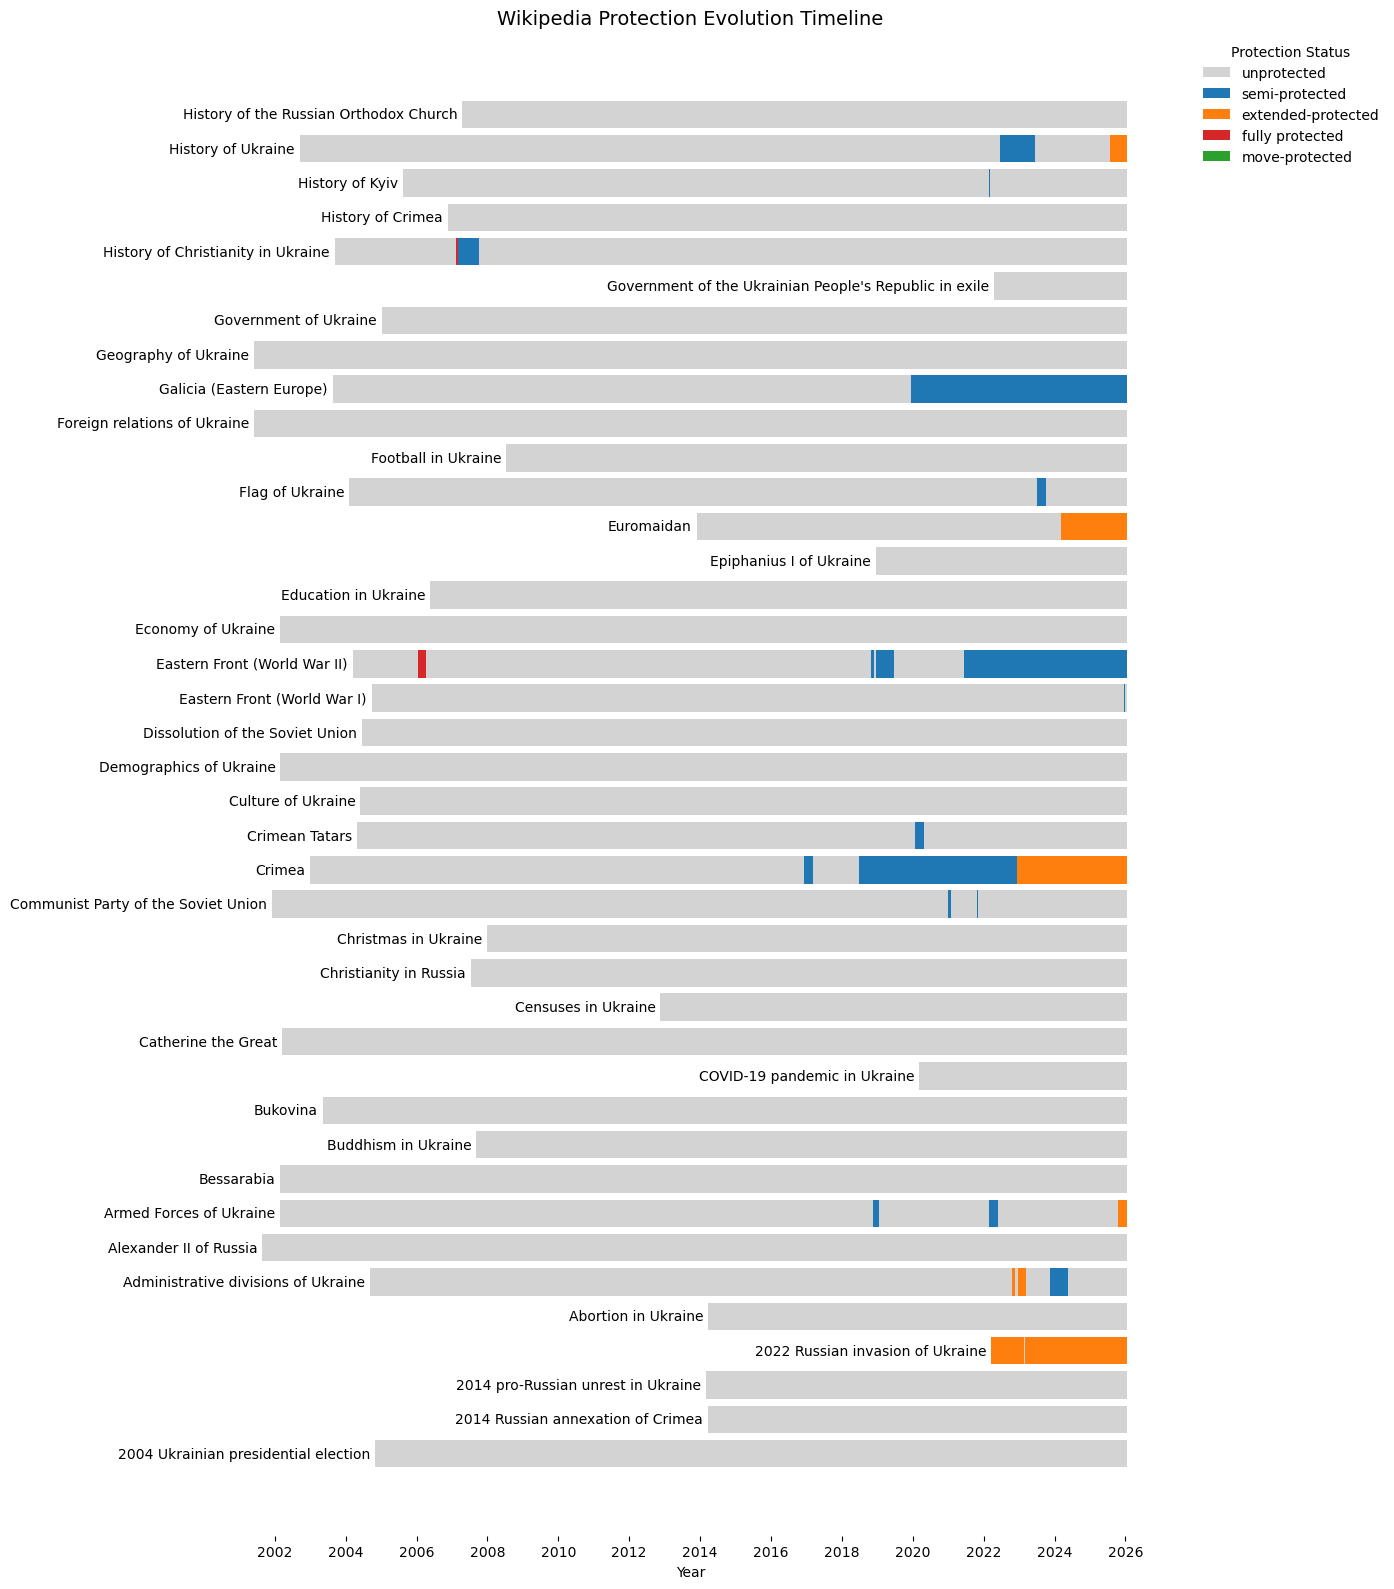

In [64]:
plot_protection_dataframe(df_protect_clean, False)

## Importance and Grades Analysis

We are now looking into the WikiProject importance feature as well as the grade assessement. Those two features are harder to get than the protection status since there is no special API parameters to retrieve those informations. We are forced to retrieve for each article every Talk Page revisions (since those feature are written in the Talk Page of an article). We are looking in those revisions banners or templates format that indicates the current importance status and grade assessement of a page.

In [94]:
WIKI_API = "https://en.wikipedia.org/w/api.php"
USER_AGENT = "DH_Project/1.0 (maxime.garambois@epfl.ch)"
SLEEP = 0.5

def request_api(params):
    """Send a request to the API with retry and user-agent."""
    headers = {"User-Agent": USER_AGENT}
    while True:
        try:
            response = requests.get(WIKI_API, params=params, headers=headers, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Retrying due to error: {e}")
            time.sleep(2)

# same idea as the protection status

def get_article_creation_date(title):
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": title,
        "rvlimit": 1,
        "rvprop": "timestamp|user|comment",
        "rvdir": "newer"  
    }

    r = requests.get(URL, params=params, headers=HEADERS)
    data = r.json()

    page = next(iter(data["query"]["pages"].values()))

    if "missing" in page:
        return None

    rev = page["revisions"][0]
    return {
        "timestamp": rev["timestamp"],
        "user": rev.get("user"),
        "comment": rev.get("comment")
    }

# as explained, we are collection every article Talk Page revisions.
def fetch_talk_revisions(article_title):
    """
    Fetch all wikitext revisions of the Talk:Article page.
    Returns a list of dicts: {rev_id, timestamp, content}
    """
    talk_title = f"Talk:{article_title}"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": talk_title,
        "rvprop": "ids|timestamp|content",
        "rvslots": "main",
        "rvlimit": "500",
    }

    revisions = []
    cont = True

    while cont:
        data = request_api(params)

        pages = data["query"]["pages"]
        page = next(iter(pages.values()))

        if "revisions" in page:
            for rev in page["revisions"]:
                revisions.append({
                    "rev_id": rev["revid"],
                    "timestamp": rev["timestamp"],
                    "content": rev["slots"]["main"].get("*", ""),
                })

        if "continue" in data:
            params.update(data["continue"])
        else:
            cont = False

        time.sleep(SLEEP)

    # sort from oldest → newest
    revisions.sort(key=lambda r: r["timestamp"])
    return revisions

def extract_metadata(wikitext):
    """
    Extract:
      - class: Prefer class from {{WikiProject banner shell|class=...}} if present,
               otherwise fall back to class from the chosen WikiProject template.
      - importance: ONLY one value:
            * If WikiProject Ukraine exists -> its importance
            * Else -> importance from the first WikiProject template found
        (If no importance is present in the chosen template -> None)

    Notes:
      - Uses brace-matching to safely extract full templates (handles nesting).
      - Tolerates whitespace, capitalization, and common talk-page formatting.
    """

    def _extract_templates_balanced(text, start_pattern):
        """
        Find all templates starting with start_pattern (case-insensitive),
        and return their full wikitext using brace matching.
        start_pattern should look like '{{WikiProject' or '{{WikiProject banner shell'.
        """
        templates = []
        lower = text.lower()
        pat = start_pattern.lower()

        i = 0
        n = len(text)
        while True:
            j = lower.find(pat.lower(), i)
            if j == -1:
                break

            # Ensure it really starts with '{{'
            if j < 2 or text[j:j+2] != "{{":
                i = j + 1
                continue

            # Brace matching from j
            depth = 0
            k = j
            while k < n - 1:
                two = text[k:k+2]
                if two == "{{":
                    depth += 1
                    k += 2
                    continue
                if two == "}}":
                    depth -= 1
                    k += 2
                    if depth == 0:
                        templates.append(text[j:k])
                        break
                    continue
                k += 1

            i = j + 2  # continue scanning after the start
        return templates

    def _normalize_class(val):
        if not val:
            return None
        v = val.strip().upper()
        # common variants
        mapping = {
            "STUB": "STUB",
            "START": "START",
            "LIST": "LIST",
            "FA": "FA",
            "FL": "FL",
            "A": "A",
            "GA": "GA",
            "B": "B",
            "C": "C",
            "NA": "NA",
        }
        return mapping.get(v, v)

    def _normalize_importance(val):
        if not val:
            return None
        v = val.strip().lower()
        mapping = {
            "top": "Top",
            "high": "High",
            "mid": "Mid",
            "middle": "Mid",   # occasional
            "low": "Low",
            "na": "NA",
            "n/a": "NA",
            "none": None,
        }
        return mapping.get(v, val.strip().capitalize())

    # --- regexes (reuse yours if they exist globally) ------------------------
    BANNER_SHELL_CLASS_RE = re.compile(r"\|\s*class\s*=\s*([A-Za-z]+)", re.IGNORECASE)
    PROJECT_NAME_RE = re.compile(r"\{\{\s*WikiProject\s*([^|}\n]+)", re.IGNORECASE)
    CLASS_RE = re.compile(r"\|\s*class\s*=\s*([A-Za-z]+)", re.IGNORECASE)
    IMPORTANCE_RE = re.compile(r"\|\s*importance\s*=\s*([A-Za-z]+)", re.IGNORECASE)

    # --- 1) Try to get class from WikiProject banner shell -------------------
    shell_class = None
    shell_templates = _extract_templates_balanced(wikitext, "{{WikiProject banner shell")
    if shell_templates:
        # If multiple shells, just take the first one encountered
        m = BANNER_SHELL_CLASS_RE.search(shell_templates[0])
        if m:
            shell_class = _normalize_class(m.group(1))

    # --- 2) Collect WikiProject templates (balanced extraction) --------------
    project_templates = _extract_templates_balanced(wikitext, "{{WikiProject")
    # Filter out banner shell itself (it also begins with "{{WikiProject ...")
    project_templates = [
        t for t in project_templates
        if not re.match(r"\{\{\s*WikiProject\s+banner\s+shell\b", t, flags=re.IGNORECASE)
    ]

    ukraine_template = None
    first_template = project_templates[0] if project_templates else None

    for t in project_templates:
        pm = PROJECT_NAME_RE.search(t)
        if not pm:
            continue
        project_name = pm.group(1).strip().lower()
        # match "Ukraine" reliably (covers "WikiProject Ukraine", "WikiProject Ukraine-related", etc.)
        if "ukraine" in project_name:
            ukraine_template = t
            break

    chosen_template = ukraine_template or first_template

    # --- 3) Extract importance ONLY from chosen template ---------------------
    importance_rating = None
    class_rating = shell_class  # prefer shell class if available

    if chosen_template:
        imp_match = IMPORTANCE_RE.search(chosen_template)
        if imp_match:
            importance_rating = _normalize_importance(imp_match.group(1))

        # If shell didn't provide class, fall back to chosen template class
        if class_rating is None:
            class_match = CLASS_RE.search(chosen_template)
            if class_match:
                class_rating = _normalize_class(class_match.group(1))

    return {
        "class": class_rating,
        "importance": importance_rating,
    }

# Same idea as for the protection status
def build_metadata_timeline(talk_revisions):
    """
    Returns a list of metadata changes:
    [
        {
            "timestamp": "...",
            "rev_id": ...,
            "class": "C",
            "importance": "High",
        },
        ...
    ]
    Only stores metadata when it changes.
    """
    timeline = []
    last_state = {"class": None, "importance": None}

    for rev in talk_revisions:
        meta = extract_metadata(rev["content"])

        if meta != last_state:
            timeline.append({
                "timestamp": rev["timestamp"],
                "rev_id": rev["rev_id"],
                **meta
            })
            last_state = meta.copy()

    return timeline    

def extract_article_metadata_timeline(article_title):
    print(f"\n=== Fetching Talk Page revisions for: {article_title} ===")
    talk_revs = fetch_talk_revisions(article_title)
    print(f"Fetched {len(talk_revs)} talk revisions.")

    print("=== Parsing metadata changes (Option B) ===")
    timeline = build_metadata_timeline(talk_revs)

    print(f"Metadata change points: {len(timeline)}")
    return timeline

# We want now to convert each feature timeline into a dataframe for the matching process with our database.
def grade_timelines_to_dataframe(timelines):
    """
    Convert the grade timelines dict into a pandas DataFrame with:
    article | start | end | grade | diff_days
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []
    now_utc = pd.Timestamp.now(tz=timezone.utc)

    for article, changes in timelines.items():

        if len(changes) == 0:
            # Try to use article creation date if available
            creation_info = get_article_creation_date(article)
            if creation_info and "timestamp" in creation_info:
                start = pd.to_datetime(creation_info["timestamp"], utc=True)
            else:
                start = pd.NaT

            diff_days = (now_utc - start).days if pd.notna(start) else None

            rows.append({
                "article": article,
                "start": start,
                "end": now_utc,
                "grade": "Unspecified",
                "diff_days": diff_days
            })
            continue

        df = pd.DataFrame(changes)

        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        df = df.sort_values("timestamp")

        # Compute end timestamps
        df["end"] = df["timestamp"].shift(-1)
        df["end"] = df["end"].fillna(now_utc)

        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            grade = row["class"]

            diff_days = (end - start).days if pd.notna(start) and pd.notna(end) else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "grade": grade if grade is not None else "Unspecified",
                "diff_days": diff_days
            })

    return pd.DataFrame(rows)

def importance_timelines_to_dataframe(timelines):
    """
    Convert the grade timelines dict into a pandas DataFrame with:
    article | start | end | grade | diff_days
    Ensures all datetimes are UTC-aware to avoid subtraction errors.
    """
    rows = []
    now_utc = pd.Timestamp.now(tz=timezone.utc)


    for article, changes in timelines.items():

        if len(changes) == 0:
            # Try to use article creation date if available
            creation_info = get_article_creation_date(article)
            if creation_info and "timestamp" in creation_info:
                start = pd.to_datetime(creation_info["timestamp"], utc=True)
            else:
                start = pd.NaT

            diff_days = (now_utc - start).days if pd.notna(start) else None

            rows.append({
                "article": article,
                "start": start,
                "end": now_utc,
                "importance": "Unspecified",
                "diff_days": diff_days
            })
            continue

        df = pd.DataFrame(changes)

        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        df = df.sort_values("timestamp")

        # Compute end timestamps
        df["end"] = df["timestamp"].shift(-1)
        df["end"] = df["end"].fillna(now_utc)

        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            importance = row.get("importance")

            diff_days = (end - start).days if pd.notna(start) and pd.notna(end) else None

            rows.append({
                "article": article,
                "start": start,
                "end": end,
                "importance": importance if importance is not None else "Unspecified",
                "diff_days": diff_days
            })

    return pd.DataFrame(rows)

def plot_grade_quality_dataframe(grade_df: pd.DataFrame, wanna_save_fig: bool = False, save_path: str = None):
    """
    Gantt-style timeline representing quality-class evolution.

    Input:
        grade_df: DataFrame output of grade_timelines_to_dataframe with columns:
            - article
            - start
            - end
            - grade
            - diff_days (ignored)
    """

    GRADE_COLORS = {
        "FA": "navy",
        "FL": "royalblue",
        "A": "darkgreen",
        "GA": "green",
        "B": "limegreen",
        "C": "gold",
        "START": "orange",
        "STUB": "indianred",
        "LIST": "lightskyblue",
        "Unspecified": "lightgray",
    }

    if grade_df is None or grade_df.empty:
        raise ValueError("grade_df is empty. Nothing to plot.")

    df = grade_df.copy()

    required = {"article", "start", "end", "grade"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"grade_df is missing required columns: {sorted(missing)}")

    # Normalize datetimes
    df["start"] = pd.to_datetime(df["start"], utc=True, errors="coerce")
    df["end"]   = pd.to_datetime(df["end"],   utc=True, errors="coerce")

    # Clean invalid intervals
    df = df.dropna(subset=["article", "start", "end"])
    df = df[df["end"] > df["start"]]

    if df.empty:
        raise ValueError("After cleaning invalid intervals, nothing remains to plot.")

    df["grade"] = df["grade"].astype(str).str.strip()
    df["grade"] = df["grade"].replace({"None": "Unspecified", "nan": "Unspecified"})
    df.loc[df["grade"].str.lower() == "unspecified", "grade"] = "Unspecified"
    df.loc[df["grade"].str.lower() != "unspecified", "grade"] = df["grade"].str.upper()


    articles = sorted(df["article"].unique())
    fig, ax = plt.subplots(figsize=(14, max(2, len(articles) * 0.4)))

    height = 0.8

    for y_pos, article in enumerate(articles):
        subset = df[df["article"] == article].sort_values("start")

        # Draw bars
        for _, row in subset.iterrows():
            start = row["start"].to_pydatetime()
            end   = row["end"].to_pydatetime()
            grade = row["grade"] if pd.notna(row["grade"]) else None

            ax.broken_barh(
                [(mdates.date2num(start), mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=GRADE_COLORS.get(grade, "black"),
                edgecolor="none"
            )

        first_start = subset["start"].iloc[0].to_pydatetime()
        ax.text(
            mdates.date2num(first_start) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    legend_handles = [
        Patch(facecolor=color, label=label)
        for label, color in GRADE_COLORS.items()
        if label not in (None, "NA") 
    ]
    ax.legend(
        handles=legend_handles,
        title="Quality Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Article Quality Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        if save_path is None:
            save_path = "../../plots/Full Database/quality_timeline.png"
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

def plot_importance_dataframe(importance_df: pd.DataFrame, wanna_save_fig: bool = False, save_path: str = None):
    """
    Gantt-style timeline representing importance-class evolution.

    Input:
        importance_df: DataFrame output of importance_timelines_to_dataframe with columns:
            - article
            - start
            - end
            - importance
            - diff_days (ignored)
    """

    IMPORTANCE_COLORS = {
        "Top": "magenta",
        "High": "orange",
        "Mid": "lime",
        "Low": "royalblue",
        "Unspecified": "lightgray",
    }

    if importance_df is None or importance_df.empty:
        raise ValueError("importance_df is empty. Nothing to plot.")

    df = importance_df.copy()

    required = {"article", "start", "end", "importance"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"importance_df is missing required columns: {sorted(missing)}")

    # Normalize datetimes
    df["start"] = pd.to_datetime(df["start"], utc=True, errors="coerce")
    df["end"]   = pd.to_datetime(df["end"],   utc=True, errors="coerce")

    # Clean invalid intervals
    df = df.dropna(subset=["article", "start", "end"])
    df = df[df["end"] > df["start"]]

    if df.empty:
        raise ValueError("After cleaning invalid intervals, nothing remains to plot.")

    # Normalize importance strings a bit
    def _norm_imp(x):
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return None
        s = str(x).strip().lower()
        mapping = {"top": "Top", "high": "High", "mid": "Mid", "middle": "Mid", "low": "Low", "na": "NA"}
        return mapping.get(s, str(x).strip())

    df["importance"] = df["importance"].map(_norm_imp)

    articles = sorted(df["article"].unique())
    fig, ax = plt.subplots(figsize=(14, max(2, len(articles) * 0.4)))

    height = 0.8

    for y_pos, article in enumerate(articles):
        subset = df[df["article"] == article].sort_values("start")

        for _, row in subset.iterrows():
            start = row["start"].to_pydatetime()
            end   = row["end"].to_pydatetime()
            imp   = row["importance"]

            ax.broken_barh(
                [(mdates.date2num(start), mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=IMPORTANCE_COLORS.get(imp, "black"),
                edgecolor="none"
            )

        first_start = subset["start"].iloc[0].to_pydatetime()
        ax.text(
            mdates.date2num(first_start) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    legend_handles = [
        Patch(facecolor=color, label=(label if label is not None else "None"))
        for label, color in IMPORTANCE_COLORS.items()
    ]
    ax.legend(
        handles=legend_handles,
        title="Importance Class",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Article Importance Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        if save_path is None:
            save_path = "../../plots/Full Database/importance_timeline.png"
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

In [70]:
importance_grade_timelines = {} # needed to build the timelines and build the plot 

for title in articles:
    importance_grade_timelines[title] = extract_article_metadata_timeline(title)

importance_df = importance_timelines_to_dataframe(importance_grade_timelines)


=== Fetching Talk Page revisions for: 2004 Ukrainian presidential election ===
Fetched 89 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 2

=== Fetching Talk Page revisions for: 2014 Russian annexation of Crimea ===
Fetched 2387 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 4

=== Fetching Talk Page revisions for: 2014 pro-Russian unrest in Ukraine ===
Fetched 3241 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 9

=== Fetching Talk Page revisions for: 2022 Russian invasion of Ukraine ===
Fetched 260 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 1

=== Fetching Talk Page revisions for: Abortion in Ukraine ===
Fetched 15 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 5

=== Fetching Talk Page revisions for: Administrative divisions of Ukraine ===
Fetched 245 talk revisions.
=== Parsing metadata changes 

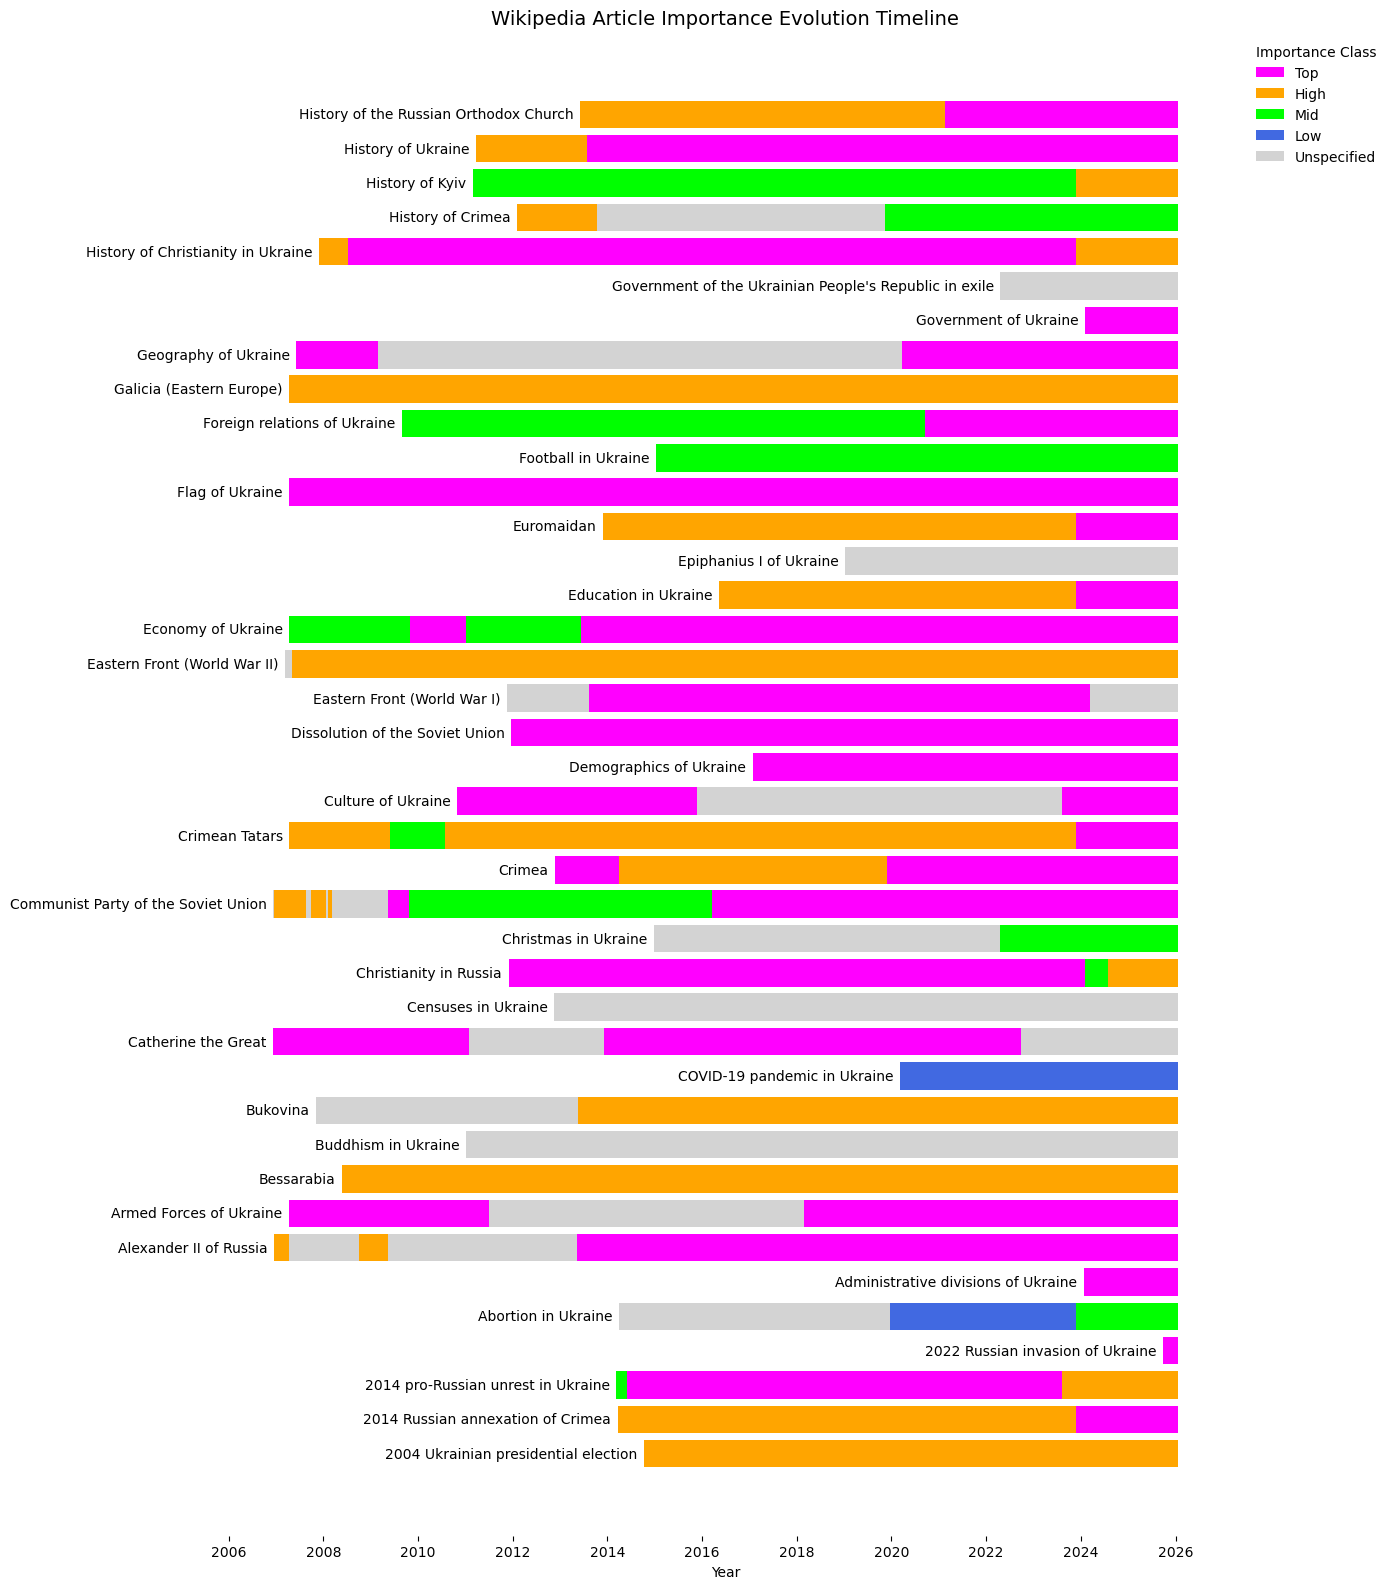

In [80]:
def clean_importance_df(dataframe):
    df = dataframe.copy()
    df['importance'] = (
    df['importance']
    .replace({None: "Unspecified"})
    .fillna("Unspecified")
    )
    return df

plot_importance_dataframe(importance_df, False)

In [77]:
# safety checks

# importance_df['article'].nunique()
# importance_df['importance'].unique()
# importance_df[importance_df['diff_days'] < 0]
importance_df

,article,start,end,importance,diff_days
0,2004 Ukrainian presidential election,2014-10-07 10:18:05+00:00,2025-09-30 02:42:32+00:00,High,4010
1,2004 Ukrainian presidential election,2025-09-30 02:42:32+00:00,2026-01-19 13:48:41.099693+00:00,High,111
2,2014 Russian annexation of Crimea,2014-03-19 20:35:01+00:00,2014-03-20 13:26:10+00:00,Low,0
3,2014 Russian annexation of Crimea,2014-03-20 13:26:10+00:00,2014-12-19 13:46:12+00:00,High,274
4,2014 Russian annexation of Crimea,2014-12-19 13:46:12+00:00,2023-11-24 03:06:27+00:00,High,3261
...,...,...,...,...,...
169,History of Ukraine,2025-02-01 00:05:17+00:00,2026-01-19 13:48:41.099693+00:00,Top,352
170,History of the Russian Orthodox Church,2013-06-06 15:36:01+00:00,2013-07-06 16:02:33+00:00,High,30
171,History of the Russian Orthodox Church,2013-07-06 16:02:33+00:00,2021-02-20 08:40:04+00:00,High,2785
172,History of the Russian Orthodox Church,2021-02-20 08:40:04+00:00,2024-02-15 03:46:41+00:00,Top,1089


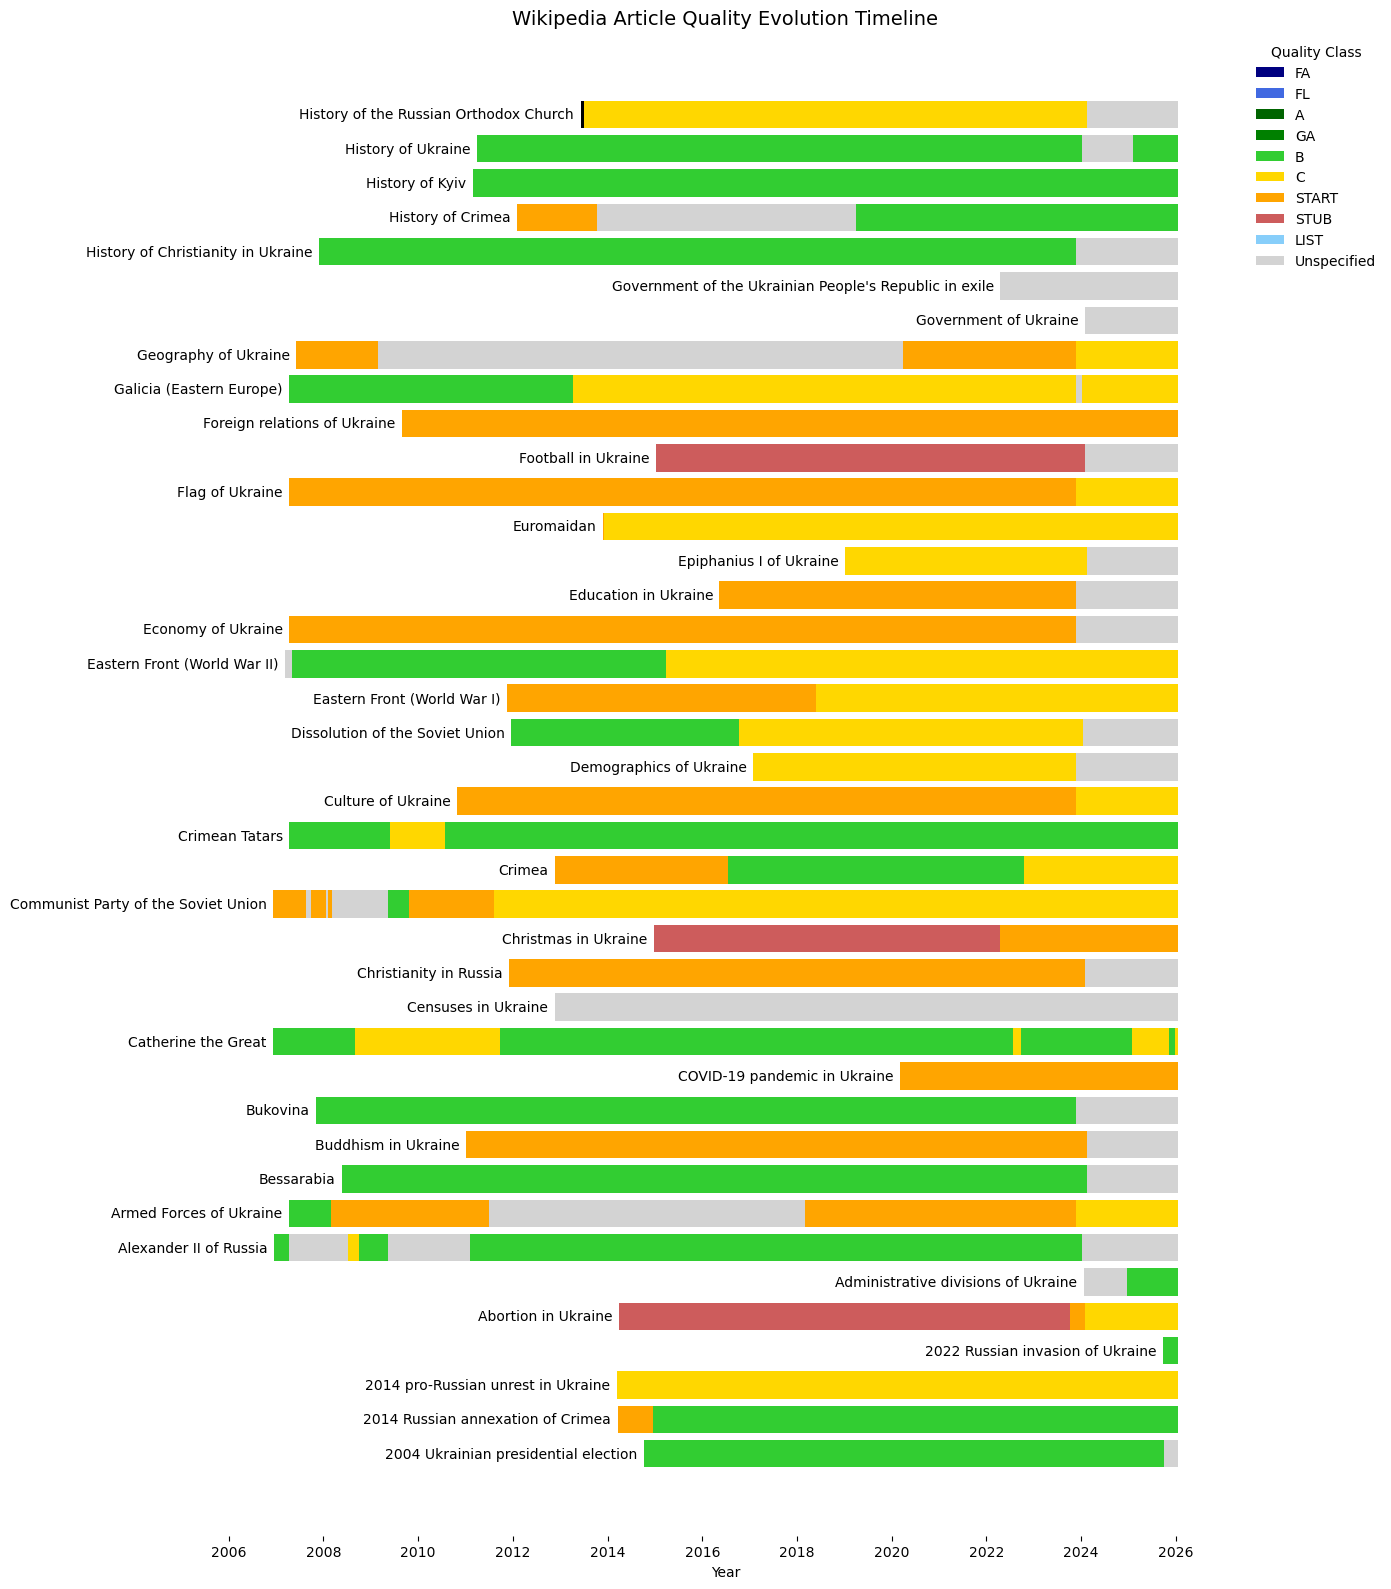

In [95]:
def clean_grade_df(dataframe):
    df = dataframe.copy()
    df['grade'] = (
    df['grade']
    .replace({None: "Unspecified"})
    .fillna("Unspecified")
    )
    return df

#grade_df_clean = clean_grade_df(grade_df)
#grade_df['article'].nunique()
grade_df['grade'].unique()
#grade_df[grade_df['diff_days'] <0 ]

plot_grade_quality_dataframe(grade_df, False)

In [85]:
quality_grade_timelines = {} # needed to build the timelines and build the plot 

for title in articles:
    quality_grade_timelines[title] = extract_article_metadata_timeline(title)

grade_df = grade_timelines_to_dataframe(quality_grade_timelines)


=== Fetching Talk Page revisions for: 2004 Ukrainian presidential election ===
Fetched 89 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 2

=== Fetching Talk Page revisions for: 2014 Russian annexation of Crimea ===
Fetched 2387 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 4

=== Fetching Talk Page revisions for: 2014 pro-Russian unrest in Ukraine ===
Fetched 3241 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 9

=== Fetching Talk Page revisions for: 2022 Russian invasion of Ukraine ===
Fetched 260 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 1

=== Fetching Talk Page revisions for: Abortion in Ukraine ===
Fetched 15 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 5

=== Fetching Talk Page revisions for: Administrative divisions of Ukraine ===
Fetched 245 talk revisions.
=== Parsing metadata changes 

## Vital Level

In [115]:
WIKI_API = "https://en.wikipedia.org/w/api.php"
USER_AGENT = "DH_Project/1.0 (maxime.garambois@epfl.ch)"
SLEEP = 0.5

def request_api(params):
    """Send a request to the API with retry and user-agent."""
    headers = {"User-Agent": USER_AGENT}
    while True:
        try:
            response = requests.get(WIKI_API, params=params, headers=headers, timeout=10)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"Retrying due to error: {e}")
            time.sleep(2)

def fetch_talk_revisions(article_title):
    """
    Fetch all wikitext revisions of the Talk:Article page.
    Returns a list of dicts: {rev_id, timestamp, content}
    """
    talk_title = f"Talk:{article_title}"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "titles": talk_title,
        "rvprop": "ids|timestamp|content",
        "rvslots": "main",
        "rvlimit": "500",
    }

    revisions = []
    cont = True

    while cont:
        data = request_api(params)

        pages = data["query"]["pages"]
        page = next(iter(pages.values()))

        if "revisions" in page:
            for rev in page["revisions"]:
                revisions.append({
                    "rev_id": rev["revid"],
                    "timestamp": rev["timestamp"],
                    "content": rev["slots"]["main"].get("*", ""),
                })

        if "continue" in data:
            params.update(data["continue"])
        else:
            cont = False

        time.sleep(SLEEP)

    revisions.sort(key=lambda r: r["timestamp"])
    return revisions

# We are defining some constants again to find the correct template where vital level is encoded in the raw text from
# the revisions of the articles Talk Page
VITAL_RE = re.compile(
    r"""\{\{\s*
        (?:Vital(?:\s+article)?)       
        \s*
        \|
        (?:
            level\s*=\s*([0-9])        
            |
            ([0-9])                    
        )
        .*?
        \}\}""",
    re.IGNORECASE | re.VERBOSE | re.DOTALL
)

VITAL_TEMPLATE_RE = re.compile(
    r"\{\{\s*Vital(?: article)?\s*\|[^}]*?(?:level\s*=\s*([0-9])|([0-9]))",
    re.IGNORECASE | re.DOTALL,
)

VITAL_PARAM_RE = re.compile(
    r"\|\s*(?:vital|vital[-_]?(?:article|level|importance)|va)\s*=\s*([0-9]|yes)",
    re.IGNORECASE,
)


def extract_vital_metadata(wikitext):
    """Extract vital-level metadata from a talk page revision."""

    vital_rating = None

    # Check explicit {{Vital article}} templates
    for match in VITAL_TEMPLATE_RE.finditer(wikitext):
        lvl_named, lvl_positional = match.groups()
        lvl = lvl_named or lvl_positional
        if lvl:
            vital_rating = lvl

    # Check |vital=... parameters in banner shell or WikiProjects
    for match in VITAL_PARAM_RE.finditer(wikitext):
        param = match.group(1).strip().lower()

        if param == "yes":
            vital_rating = "5"     # convention
        else:
            vital_rating = param   # numeric 1–5

    return {"vital": vital_rating}


def build_vital_metadata_timeline(talk_revisions):
    """
    Returns a list of metadata changes:
    [
        {
            "timestamp": "...",
            "rev_id": ...,
            "class": "C",
            "importance": "High",
        },
        ...
    ]
    Only stores metadata when it changes.
    """
    timeline = []
    last_state = {"vital": None}

    for rev in talk_revisions:
        meta = extract_vital_metadata(rev["content"])

        if meta != last_state:
            timeline.append({
                "timestamp": rev["timestamp"],
                "rev_id": rev["rev_id"],
                **meta
            })
            last_state = meta.copy()

    return timeline

def extract_article_vital_metadata_timeline(article_title):
    print(f"\n=== Fetching Talk Page revisions for: {article_title} ===")
    talk_revs = fetch_talk_revisions(article_title)
    print(f"Fetched {len(talk_revs)} talk revisions.")

    print("=== Parsing metadata changes (Option B) ===")
    timeline = build_vital_metadata_timeline(talk_revs)

    print(f"Metadata change points: {len(timeline)}")
    return timeline


def vital_timelines_to_dataframe(timelines):
    """
    Convert the vital timelines dict into a pandas DataFrame with:
    article | article_created | start | end | vital | diff_days
    """

    rows = []
    now_utc = pd.Timestamp.now(tz=timezone.utc)

    for article, changes in timelines.items():
        creation_info = get_article_creation_date(article)
        if creation_info and "timestamp" in creation_info:
            creation_dt = pd.to_datetime(creation_info["timestamp"], utc=True)
        else:
            creation_dt = pd.NaT

        if len(changes) == 0:
            start = creation_dt
            end = now_utc
            rows.append({
                "article": article,
                "article_created": creation_dt,
                "start": start,
                "end": end,
                "vital": "Unspecified",
                "diff_days": (end - start).days if pd.notna(start) else None
            })
            continue

        df = pd.DataFrame(changes)
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        df = df.sort_values("timestamp")

        df["end"] = df["timestamp"].shift(-1).fillna(now_utc)

        for _, row in df.iterrows():
            start = row["timestamp"]
            end = row["end"]
            vital = row["vital"] if row["vital"] is not None else "Unspecified"

            rows.append({
                "article": article,
                "article_created": creation_dt,
                "start": start,
                "end": end,
                "vital": vital,
                "diff_days": (end - start).days if pd.notna(start) and pd.notna(end) else None
            })

    return pd.DataFrame(rows)

def plot_vital_level_dataframe(df, wanna_save_fig=False):
    """
    Plot a Gantt-style timeline of Vital Level evolution.
    Only plots articles that have at least one specified vital level (1–5) at some point.
    Input: df with columns
        article | start | end | vital | diff_days
    """

    GRADE_COLORS = {
        "1": "forestgreen",
        "2": "limegreen",
        "3": "lime",
        "4": "lightseagreen",
        "5": "darkslategray",
        "Unspecified": "lightgray",   # no vital rating
    }

    df = df.copy()
    df["start"] = pd.to_datetime(df["start"], utc=True, errors="coerce")
    df["end"]   = pd.to_datetime(df["end"], utc=True, errors="coerce")

    # Clean invalid rows
    df = df.dropna(subset=["article", "start", "end"])
    df = df[df["end"] > df["start"]]

    def _norm_vital(v):
        if pd.isna(v) or str(v).strip() == "":
            return "Unspecified"
        return str(v).strip()

    df["vital_key"] = df["vital"].map(_norm_vital)

    keep_articles = (
        df.groupby("article")["vital_key"]
          .apply(lambda s: (s != "Unspecified").any())
    )
    df = df[df["article"].isin(keep_articles[keep_articles].index)]

    if df.empty:
        raise ValueError("No articles with specified vital levels (1–5) to plot.")

    articles = sorted(df["article"].unique())
    fig, ax = plt.subplots(figsize=(14, len(articles) * 0.5))

    y_pos = 0
    height = 0.8

    for article in articles:
        df_a = df[df["article"] == article].sort_values("start")

        for _, row in df_a.iterrows():
            start = row["start"]
            end   = row["end"]
            vital_key = row["vital_key"]

            ax.broken_barh(
                [(mdates.date2num(start),
                  mdates.date2num(end) - mdates.date2num(start))],
                (y_pos, height),
                facecolors=GRADE_COLORS.get(vital_key, "black"),
                edgecolor="none"
            )

        ax.text(
            mdates.date2num(df_a["start"].min()) - 50,
            y_pos + height / 2,
            article,
            va="center",
            ha="right"
        )

        y_pos += 1

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel("Year")
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    legend_handles = [
        Patch(facecolor=color, label=("Unspecified" if label == "Unspecified" else f"Level {label}"))
        for label, color in GRADE_COLORS.items()
    ]

    ax.legend(
        handles=legend_handles,
        title="Vital Level",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False
    )

    plt.title("Wikipedia Article Vital Level Evolution Timeline", fontsize=14)
    plt.tight_layout()

    if wanna_save_fig:
        plt.savefig(
            "../../plots/Policy Analysis/vital_level_timeline.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()

In [100]:
vital_timelines={}

for article in articles:
    
    vital_timelines[article] = extract_article_vital_metadata_timeline(article)

vital_df = vital_timelines_to_dataframe(vital_timelines)



=== Fetching Talk Page revisions for: 2004 Ukrainian presidential election ===
Fetched 89 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 0

=== Fetching Talk Page revisions for: 2014 Russian annexation of Crimea ===
Fetched 2387 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 5

=== Fetching Talk Page revisions for: 2014 pro-Russian unrest in Ukraine ===
Fetched 3241 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 0

=== Fetching Talk Page revisions for: 2022 Russian invasion of Ukraine ===
Fetched 260 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 2

=== Fetching Talk Page revisions for: Abortion in Ukraine ===
Fetched 15 talk revisions.
=== Parsing metadata changes (Option B) ===
Metadata change points: 0

=== Fetching Talk Page revisions for: Administrative divisions of Ukraine ===
Fetched 245 talk revisions.
=== Parsing metadata changes 

In [103]:
def clean_vital_df(dataframe):
    df = dataframe.copy()
    df['vital'] = (
    df['vital']
    .replace({None: "Unspecified"})
    .fillna("Unspecified")
    )
    return df

#vital_df['article'].nunique()
#vital_df['vital'].unique()
#vital_df[vital_df['diff_days'] <0]
#vital_df = clean_vital_df(vital_df)

,article,article_created,start,end,vital,diff_days


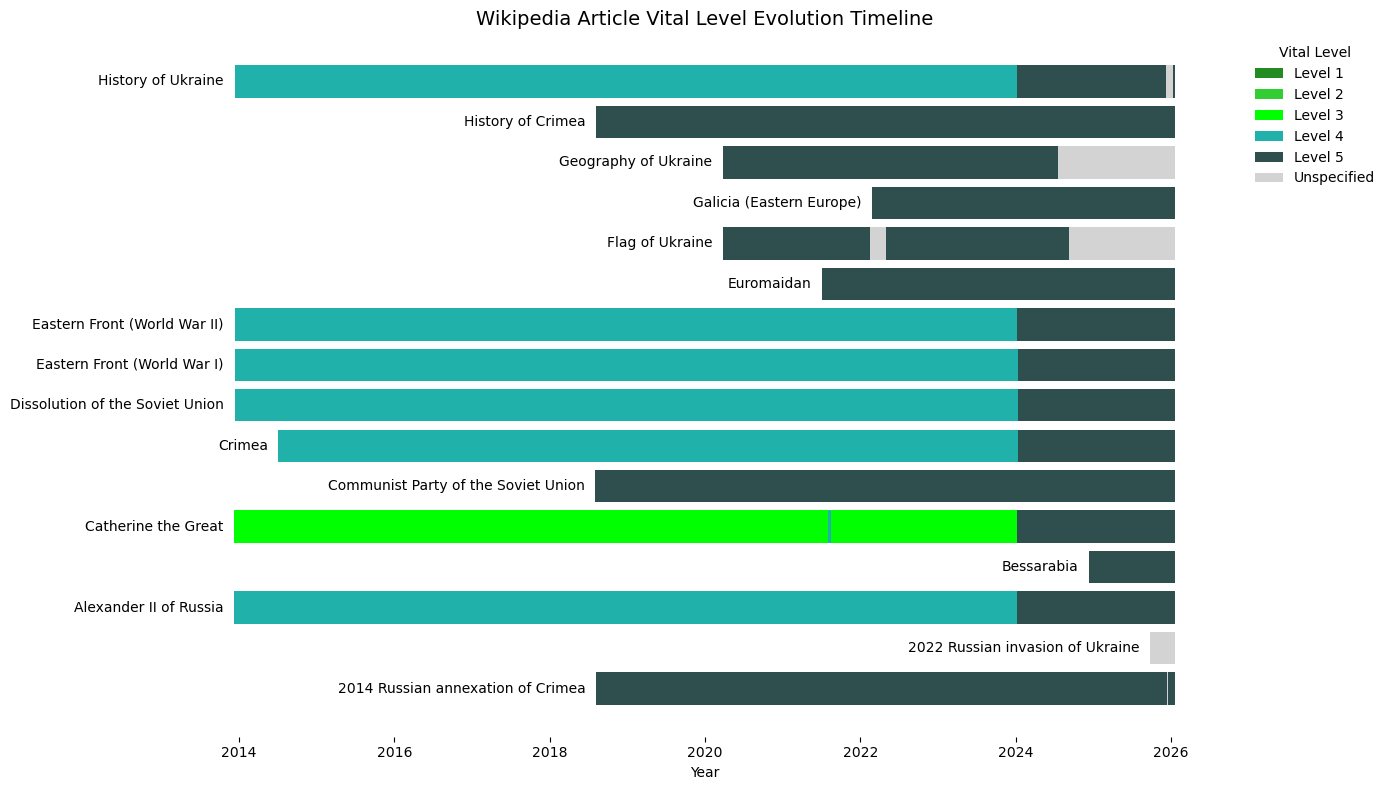

In [116]:
plot_vital_level_dataframe(vital_df, True)

## Match and Plot

In [106]:
def match_features_with_df(grade_dataframe, importance_dataframe, vital_dataframe, dataframe):

    df = dataframe.copy()
    
    # Step 1: convert date column
    df["date"] = pd.to_datetime(df["date"], utc=True)
    df = df.sort_values('date', ascending=False)
    
    # Step 2: assign importance based on timeline intervals
    for idx, row in df.iterrows():
        article = row["article"]
        date_df = row["date"]
    
        # find the timeline rows for this article
        grade_subset      = grade_dataframe[grade_dataframe["article"] == article]
        importance_subset = importance_dataframe[importance_dataframe["article"] == article]
        vital_subset = vital_dataframe[vital_dataframe["article"] == article]
    
        # loop over intervals for this article for grade_dataframe
        for _, tg in grade_subset.iterrows():
            grade_start = tg["start"]
            grade_end   = tg["end"]
    
            # check if the date is within that interval
            if grade_start <= date_df < grade_end:
                df.loc[idx, "grade"] = tg["grade"]
                break  

        # loop over intervals for this article for importance_dataframe
        for _, ti in importance_subset.iterrows():
            importance_start = ti["start"]
            importance_end   = ti["end"]
    
            # check if the date is within that interval
            if importance_start <= date_df < importance_end:
                df.loc[idx, "importance"] = ti["importance"]
                break    

        # loop over intervals for this article for vital_dataframe
        for _, tv in vital_subset.iterrows():
            vital_start = tv["start"]
            vital_end   = tv["end"]
    
            # check if the date is within that interval
            if vital_start <= date_df < vital_end:
                df.loc[idx, "vital"] = tv["vital"]
                break  

    return df

df_final = match_features_with_df(grade_df, importance_df, vital_df, df)

In [123]:
def plot_weap_vs_importance(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
        "Top": "magenta", 
        "High": "orange", 
        "Mid": "lime", 
        "Low": "royalblue", 
        "Unspecified": "lightgray",
    }
    
    df_sub = dataframe.groupby(['weaponised', 'importance']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["Unspecified", "Low", "Mid", "High", "Top"]

    df_plot["importance"] = pd.Categorical(df_plot["importance"], categories=order, ordered=True)
    
    pivot = df_plot.pivot(index="importance", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Distribution of Weaponised vs Not Weaponised Edits by Importance Level"
    else:
        # default = count
        y_label = "Count"
        title = "Edit Count by Importance Level and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Importance Level")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        filename = f"Importance_vs_Weaponisation_{distribution_type}.png"
        plt.savefig(
            f"../../plots/Policy Analysis/{filename}",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

def plot_weap_vs_grade(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
    }
    
    df_sub = dataframe.groupby(['weaponised', 'grade']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["Unspecified", "STUB", "START", "C", "B", "A", "GA", "FL", "FA"]

    df_plot["grade"] = pd.Categorical(df_plot["grade"], categories=order, ordered=True)
    
    pivot = df_plot.pivot(index="grade", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Distribution of Weaponised vs Not Weaponised Edits by Article Quality Grade"
    else:
        y_label = "Count"
        title = "Edit Count by Article Quality Grade and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Grade Level")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            f"../../plots/Policy Analysis/{title}.png",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

def plot_weap_vs_protection(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
    }
    
    df_sub = dataframe.groupby(['weaponised', 'status']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["unprotected", "semi-protected", "extended-protected", "fully protected"]

    df_plot["status"] = pd.Categorical(df_plot["status"], categories=order, ordered=True)
    
    pivot = df_plot.pivot(index="status", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Distribution of Weaponised vs Not Weaponised Edits by Protection Status"
    else:
        y_label = "Count"
        title = "Edit Count by Protection Status and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Protection Level")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            f"../../plots/Policy Analysis/{title}.png",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

def plot_weap_vs_vital(dataframe, wanna_save=False, distribution_type="count"):
    
    custom_palette = { 
        "Weaponised": "#ed2939",             
        "Not Weaponised": "forestgreen",              
    }
    
    df_sub = dataframe.groupby(['weaponised', 'vital']).size().reset_index(name="count")
    df_plot = df_sub.copy()

    order = ["Unspecified", "5", "4", "3", "2", "1"]

    df_plot["vital"] = pd.Categorical(df_plot["vital"], categories=order, ordered=True)

    pivot = df_plot.pivot(index="vital", columns="weaponised", values="count")
    pivot = pivot.reindex(order).fillna(0)

    if distribution_type == "percentage":
        pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
        y_label = "Percentage (%)"
        title = "Distribution of Weaponised vs Not Weaponised Edits by Vital Level"
    else:
        y_label = "Count"
        title = "Edit Count by Vital Level and Weaponisation Status"
    
    weapon_palette = {
        "Weaponised": custom_palette["Weaponised"],
        "Not Weaponised": custom_palette["Not Weaponised"]
    }
    
    pivot.plot(
        kind="bar", 
        figsize=(10,6),
        color=[weapon_palette[col] for col in pivot.columns]
    )
    
    plt.title(title)
    plt.xlabel("Vital Level")
    plt.ylabel(y_label)
    plt.xticks(rotation=0)
    plt.legend(title="Weaponised Status")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            f"../../plots/Policy Analysis/{title}.png",
            dpi=300, bbox_inches="tight"
        )

    plt.show()

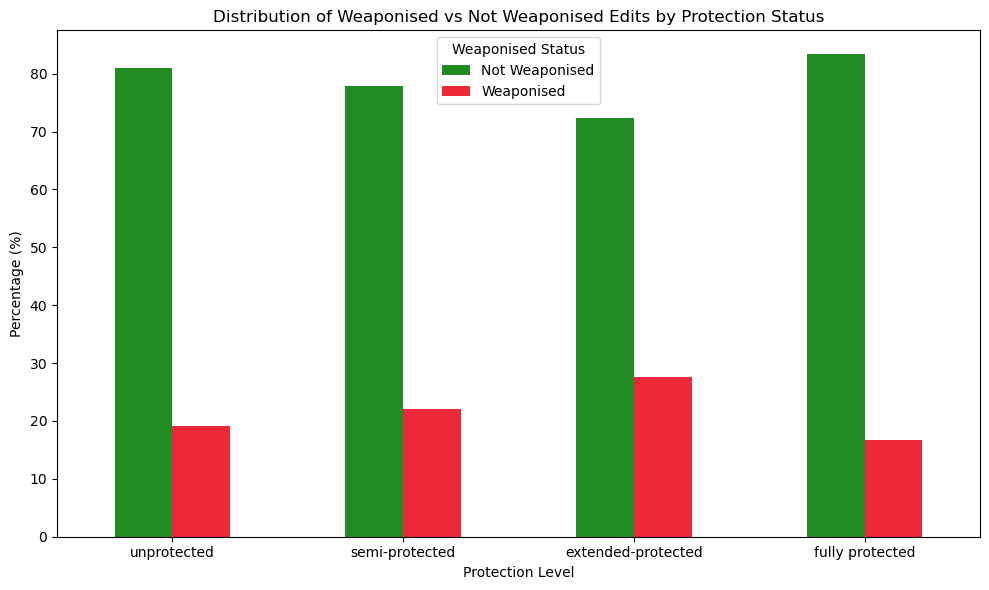

In [110]:
plot_weap_vs_protection(df_match_protect, False, 'percentage')

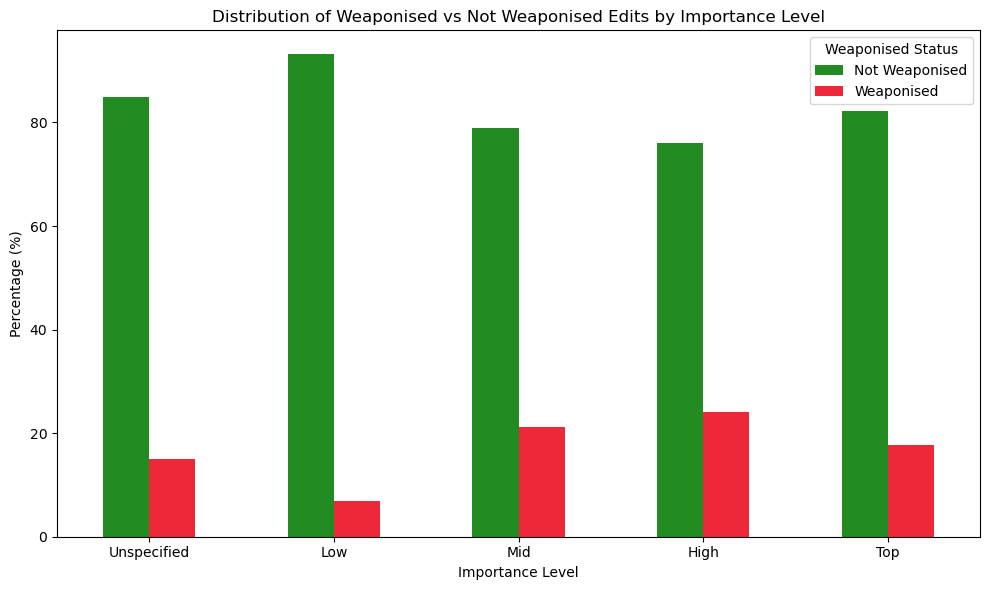

In [119]:
plot_weap_vs_importance(df_final, False, 'percentage')

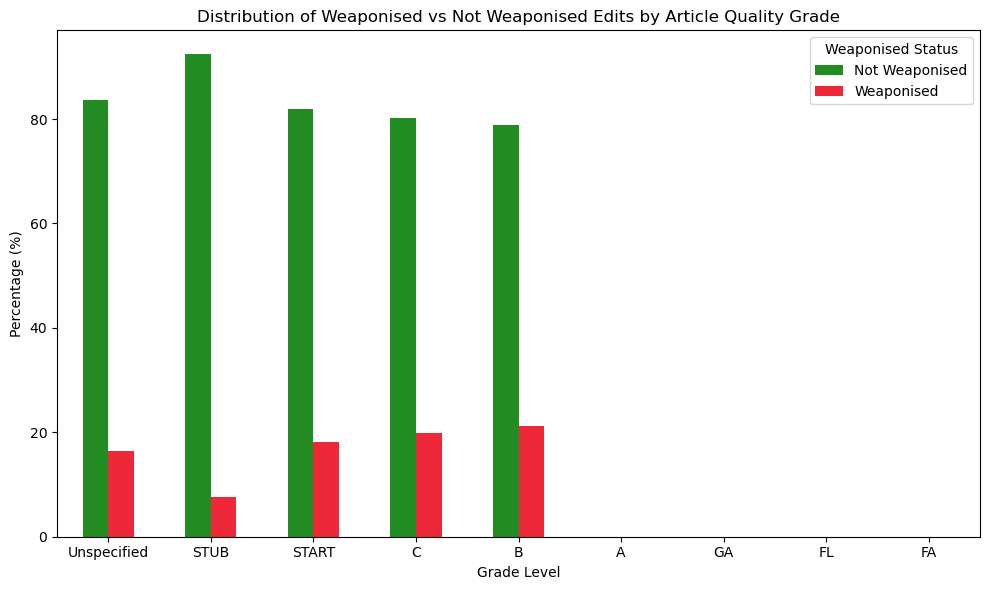

In [113]:
plot_weap_vs_grade(df_final, False, 'percentage')

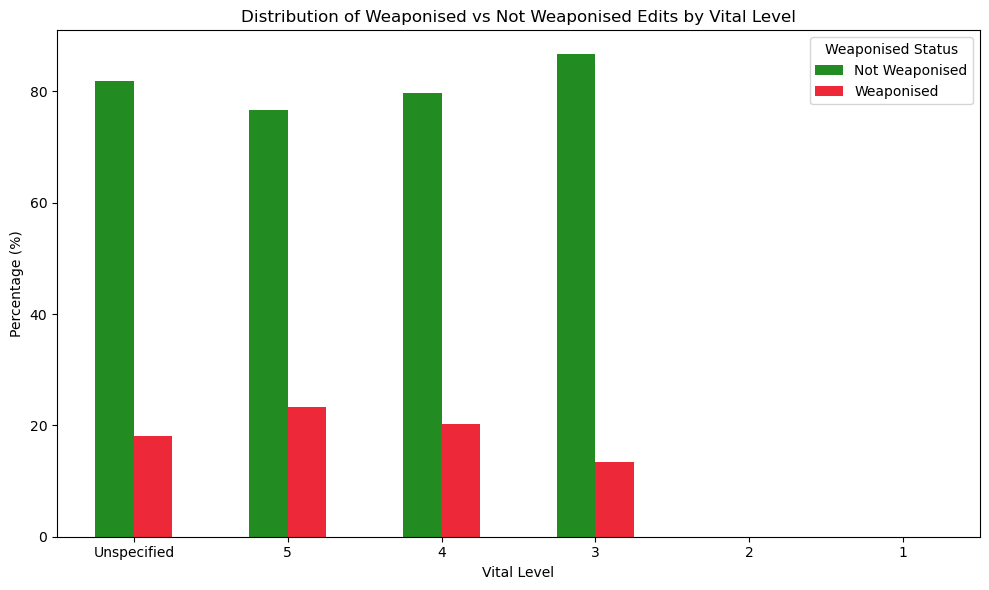

In [124]:
plot_weap_vs_vital(df_final, False, 'percentage')